# Assignment 2

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Human Value Detection, Multi-label classification, Transformers, BERT

This Jupyter Notebook document is our implementation of Assignment 2. 

Group members:
- Stricescu Razvan Ciprian
- Matteo Belletti
- Alessandro Pasi


# Imports and libraries needed

In [1]:
#%pip install pandas
#%pip install numpy
#%pip install nltk
#%pip install scikit-learn
#%pip install transformers
#%pip install matplotlib
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
from sklearn.metrics import classification_report
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
from sklearn.feature_extraction.text import  TfidfVectorizer
from torch import cuda
import torch
import transformers
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, ConcatDataset
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup, RobertaConfig
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cpu


## Task 1: Corpus:

We address a multi-label classification problem. We consider only level 3 categories which are the following:
- Openness to change
- Self-enhancement
- Conservation
- Self-transcendence

We're gonna merge annotations of level 2 categories belonging to the same level 3 category. For example, we merge the annotations of the level 2 categories "Stimulation" and "Hedonism" into the level 3 category "Openness to change".

Encoding to pandas dataframe:

In [3]:
arg_train = pd.read_csv('arguments/arguments-training.tsv', sep='\t')
print(arg_train.head(1))
print(f"Shape of the training data: {arg_train.shape}")
arg_val = pd.read_csv('arguments/arguments-validation.tsv', sep='\t')
print(f"Shape of the validation data: {arg_val.shape}")
arg_test = pd.read_csv('arguments/arguments-test.tsv', sep='\t')
print(f"Shape of the test data: {arg_test.shape}")

  Argument ID                   Conclusion       Stance  \
0      A01002  We should ban human cloning  in favor of   

                                             Premise  
0  we should ban human cloning as it will only ca...  
Shape of the training data: (5393, 4)
Shape of the validation data: (1896, 4)
Shape of the test data: (1576, 4)


In [4]:
lab_train = pd.read_csv('arguments/labels-training.tsv', sep='\t')
print(lab_train.head(1))
print(f"Shape of the training data: {lab_train.shape}")
lab_val = pd.read_csv('arguments/labels-validation.tsv', sep='\t')
print(f"Shape of the validation data: {lab_val.shape}")
lab_test = pd.read_csv('arguments/labels-test.tsv', sep='\t')
print(f"Shape of the test data: {lab_test.shape}")

  Argument ID  Self-direction: thought  Self-direction: action  Stimulation  \
0      A01002                        0                       0            0   

   Hedonism  Achievement  Power: dominance  Power: resources  Face  \
0         0            0                 0                 0     0   

   Security: personal  ...  Tradition  Conformity: rules  \
0                   0  ...          0                  0   

   Conformity: interpersonal  Humility  Benevolence: caring  \
0                          0         0                    0   

   Benevolence: dependability  Universalism: concern  Universalism: nature  \
0                           0                      0                     0   

   Universalism: tolerance  Universalism: objectivity  
0                        0                          0  

[1 rows x 21 columns]
Shape of the training data: (5393, 21)
Shape of the validation data: (1896, 21)
Shape of the test data: (1576, 21)


Now for each split we merge arguments and labels into a single dataframe.

In [5]:
df_train = arg_train.merge(lab_train, on='Argument ID')
df_val = arg_val.merge(lab_val, on='Argument ID')
df_test = arg_test.merge(lab_test, on='Argument ID')
print(f"Shape of the training data: {df_train.shape}")
print(f"Shape of the validation data: {df_val.shape}")
print(f"Shape of the test data: {df_test.shape}")

Shape of the training data: (5393, 24)
Shape of the validation data: (1896, 24)
Shape of the test data: (1576, 24)


We merge level 2 categories into level 3 categories. We also create new dataframes for the cp and cps tasks.

In [6]:
# Merge the level 2 categories to level 3
# They start from column 4 so we can just add 4 to the level 2 category
# Openness to change: 4 columns
# Conservation: columns 4 columns
# Self-enhancement: 6 columns
# Self-transcendence: 6 columns

def merge_categories(df):
    # Logical or 
    df['Openness to change'] = df[df.columns[4:8]].any(axis=1).astype(int)
    df['Conservation'] = df[df.columns[7:12]].any(axis=1).astype(int)
    df['Self-enhancement'] = df[df.columns[11:18]].any(axis=1).astype(int)
    df['Self-transcendence'] = df[df.columns[17:24]].any(axis=1).astype(int)
    df = df.drop(df.columns[4:24], axis=1)
    return df

# get column names
df_train = merge_categories(df_train)
df_val = merge_categories(df_val)
df_test = merge_categories(df_test)
print(f"Shape of the training data: {df_train.shape}")
print(f"Shape of the validation data: {df_val.shape}")
print(f"Shape of the test data: {df_test.shape}")

# Create the dataframes for the cp task
df_traincp = df_train.copy()
df_valcp = df_val.copy()
df_testcp = df_test.copy()
df_traincp["text"] = df_traincp["Conclusion"] + " " + df_traincp["Premise"]
df_valcp["text"] = df_valcp["Conclusion"] + " " + df_valcp["Premise"]
df_testcp["text"] = df_testcp["Conclusion"] + " " + df_testcp["Premise"]
print(f"Shape of the training data for the cp task: {df_traincp.shape}")

# Create the dataframes for the cps task
df_traincps = df_train.copy()
df_valcps = df_val.copy()
df_testcps = df_test.copy()
df_traincps["Stance"] = df_traincps["Stance"].replace("against", "0")
df_valcps["Stance"] = df_valcps["Stance"].replace("against", "0")
df_testcps["Stance"] = df_testcps["Stance"].replace("against", "0")
df_valcps["Stance"] = df_valcps["Stance"].replace("in favor of", "1")
df_traincps["Stance"] = df_traincps["Stance"].replace("in favor of", "1")
df_testcps["Stance"] = df_testcps["Stance"].replace("in favor of", "1")
df_traincps["text"] = df_traincp["Conclusion"] + " " + df_traincp["Premise"] + " " + df_traincps["Stance"]
df_valcps["text"] = df_valcp["Conclusion"] + " " + df_valcp["Premise"] + " " + df_valcps["Stance"]
df_testcps["text"] = df_testcp["Conclusion"] + " " + df_testcp["Premise"] + " " + df_testcps["Stance"]
print(f"Shape of the training data for the cps task: {df_traincps.shape}")

Shape of the training data: (5393, 8)
Shape of the validation data: (1896, 8)
Shape of the test data: (1576, 8)
Shape of the training data for the cp task: (5393, 9)
Shape of the training data for the cps task: (5393, 9)


#### Text encoding:

We encode the Premise column in order to check the sentence length distribution.

In [7]:
nltk.download('punkt')
train_text = df_train['Premise'].tolist()
train_lengths = [len(word_tokenize(x)) for x in tqdm(train_text)]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\39328\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
  0%|          | 0/5393 [00:00<?, ?it/s]

100%|██████████| 5393/5393 [00:01<00:00, 4599.27it/s]


Plotting the distribution of the number of words per argument:

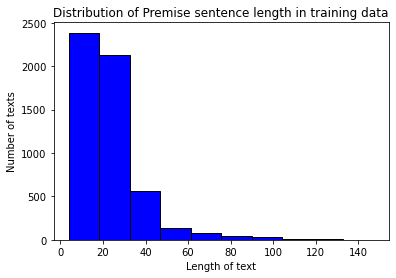

In [8]:
plt.hist(train_lengths, color='blue', edgecolor='black')
plt.xlabel('Length of text')
plt.ylabel('Number of texts')
plt.title('Distribution of Premise sentence length in training data')
plt.show()

Text preproccesing with nltk: 

We use nltk to remove stopwords and punctuation from the arguments and we also lemmitize the words.

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
punct = string.punctuation
bad_symbols = re.compile('[^a-z ]')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\39328\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\39328\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\39328\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [10]:
def preprocess(text):
    text = text.lower()
    text = bad_symbols.sub('', text)
    text = ' '.join(word for word in text.split() if word not in punct)
    text = ' '.join(word for word in text.split() if word not in stopwords)
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    return text

In [11]:
train = df_train.copy()
train['Preprocessed'] = train['Premise'].apply(preprocess)
train = train.drop(columns=train.columns[1:4])
val = df_val.copy()
val['Preprocessed'] = val['Premise'].apply(preprocess)
val = val.drop(columns=val.columns[1:4])
test = df_test.copy()
test['Preprocessed'] = test['Premise'].apply(preprocess)
test = test.drop(columns=test.columns[1:4])
print(f"Train dataframe after preprocessing:\n")
train.head(1)

Train dataframe after preprocessing:



,Argument ID,Openness to change,Conservation,Self-enhancement,Self-transcendence,Preprocessed
0,A01002,0,0,1,0,ban human cloning cause huge issue bunch human...


We tokenize the the data using TF-IDF vectorizer. We do the same for the validation and test sets which we will use later for the baseline models.

In [12]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train['Preprocessed'])
X_val = vectorizer.transform(val['Preprocessed'])
X_test = vectorizer.transform(test['Preprocessed'])

print(f"Shape of the training data: {X_train.shape}")
print(f"Shape of the validation data: {X_val.shape}")
print(f"Shape of the test data: {X_test.shape}")
print(f"Size of the vocabulary: {len(vectorizer.vocabulary_)}")

Shape of the training data: (5393, 6836)
Shape of the validation data: (1896, 6836)
Shape of the test data: (1576, 6836)
Size of the vocabulary: 6836


# Task 2: Model definition

You are tasked to define several neural models for multi-label classification.

### Instructions

* **Baseline**: implement a random uniform classifier (an individual classifier per category).
* **Baseline**: implement a majority classifier (an individual classifier per category).

<br/>

* **BERT w/ C**: define a BERT-based classifier that receives an argument **conclusion** as input.
* **BERT w/ CP**: add argument **premise** as an additional input.
* **BERT w/ CPS**: add argument premise-to-conclusion **stance** as an additional input.

Evaluation report for baseline models:

In [13]:
def evaluate(Y_test, Y_pred):
    report = classification_report(Y_test, Y_pred)
    print(report)

Y_test = test.iloc[:, 1:5].values # get as array the labels of the test set [oppenness, conservation, self-enhancement, self-transcendence]
Y_val = val.iloc[:, 1:5].values # get as array the labels of the validation set [oppenness, conservation, self-enhancement, self-transcendence]

## Baseline models:

As baseline models we implemented a random uniform classifier and a majority classifier using the sklearn library which already has these models implemented.

We implment a classifier for each category.

### Implement a random uniform classifier:

In [14]:
from sklearn.dummy import DummyClassifier

uniform_classifier_openness = DummyClassifier(strategy='uniform')
uniform_classifier_conserv = DummyClassifier(strategy='uniform')
uniform_classifier_self_enh = DummyClassifier(strategy='uniform')
uniform_classifier_self_trans = DummyClassifier(strategy='uniform')

### Implement a majority classifier:

In [15]:
majority_classifier_openness = DummyClassifier(strategy='most_frequent')
majority_classifier_conserv = DummyClassifier(strategy='most_frequent')
majority_classifier_self_enh = DummyClassifier(strategy='most_frequent')
majority_classifier_self_trans = DummyClassifier(strategy='most_frequent')

## RoBERTa model:

As a BERT-based classifier we used the RoBERTa model. We used the HuggingFace library to load the model and the tokenizer. We chose the RoBERTa model because it is a more recent model than BERT and it is generally considered to be more versatile and robust.

Global variables:

In [16]:
model_name = 'roberta-base'
max_len = 100
batch_size = 16
epochs = 10
learning_rate = 2e-5
output_channels = 768
tokenizer = AutoTokenizer.from_pretrained(model_name)

Token generation for RoBERTa:

In [17]:
class RobertaDataset(Dataset):
    def __init__(self, data, labels, tokenizer, max_len):
        self.data = data
        self.targets = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        text = str(self.data[index])
        text = ' '.join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

# Create the dataset for the neural network
train_targets = df_train.iloc[:, 4:8].values
val_targets = df_val.iloc[:, 4:8].values
test_targets = df_test.iloc[:, 4:8].values

print(f"Shape of the training labels: {train_targets.shape}")
print(f"Shape of the validation labels: {val_targets.shape}")
print(f"Shape of the test labels: {test_targets.shape}")

Shape of the training labels: (5393, 4)
Shape of the validation labels: (1896, 4)
Shape of the test labels: (1576, 4)


RoBERTa model definition: 

In [18]:
class roBERTa(torch.nn.Module):
    def __init__(self, model_name):
        super(roBERTa, self).__init__()
        self.roberta = AutoModel.from_pretrained(model_name, return_dict=False)
        self.dropout = torch.nn.Dropout(p=0.3)
        self.classifier = torch.nn.Linear(output_channels, 4)
        
    def forward(self, ids, mask, token_type_ids):
        _, output = self.roberta(ids, attention_mask=mask, token_type_ids=token_type_ids)
        output = self.dropout(output)
        output = self.classifier(output)
        return output

Loss function:

In [19]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

RoBERTa w/C data preparation:

For each model we create different datasets and dataloaders based on the task we are performing.

In [20]:
train_datasetc = RobertaDataset(df_train.iloc[:, 1], train_targets, tokenizer, max_len)
val_datasetc = RobertaDataset(df_val.iloc[:, 1], val_targets, tokenizer, max_len)
test_datasetc = RobertaDataset(df_test.iloc[:, 1], test_targets, tokenizer, max_len)

print(f"Shape of the training dataset: {len(train_datasetc)}")
print(f"Shape of the validation dataset: {len(val_datasetc)}")
print(f"Shape of the test dataset: {len(test_datasetc)}")

train_dataloaderc = DataLoader(train_datasetc, batch_size=batch_size)
val_dataloaderc = DataLoader(val_datasetc, batch_size=batch_size)
test_dataloaderc = DataLoader(test_datasetc, batch_size=batch_size)

Shape of the training dataset: 5393
Shape of the validation dataset: 1896
Shape of the test dataset: 1576


Model initialization and optional gpu usage:

In [21]:
model_c = roBERTa(model_name)
model_c.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


roBERTa(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

RoBERTa w/CP data preparation:

In [22]:
train_datasetcp = RobertaDataset(df_traincp.iloc[:, 8], train_targets, tokenizer, max_len)
val_datasetcp = RobertaDataset(df_valcp.iloc[:, 8], val_targets, tokenizer, max_len)
test_datasetcp = RobertaDataset(df_testcp.iloc[:, 8], test_targets, tokenizer, max_len)


print(f"Shape of the training dataset: {len(train_datasetcp)}")
print(f"Shape of the validation dataset: {len(val_datasetcp)}")
print(f"Shape of the test dataset: {len(test_datasetcp)}")

train_dataloadercp = DataLoader(train_datasetcp, batch_size=batch_size)
val_dataloadercp = DataLoader(val_datasetcp, batch_size=batch_size)
test_dataloadercp = DataLoader(test_datasetcp, batch_size=batch_size)

Shape of the training dataset: 5393
Shape of the validation dataset: 1896
Shape of the test dataset: 1576


In [23]:
data = next(iter(train_dataloadercp))
print(data['ids'])
print(data['mask'])
tokenizer.decode(data['ids'][0])

tensor([[  0, 170, 197,  ...,   1,   1,   1],
        [  0, 170, 197,  ...,   1,   1,   1],
        [  0, 170, 197,  ...,   1,   1,   1],
        ...,
        [  0, 170, 197,  ...,   1,   1,   1],
        [  0, 170, 197,  ...,   1,   1,   1],
        [  0, 170, 197,  ...,   1,   1,   1]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


'<s>We should ban human cloning we should ban human cloning as it will only cause huge issues when you have a bunch of the same humans running around all acting the same.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

Model initialization and optional gpu usage:

In [24]:
model_cp = roBERTa(model_name)
model_cp.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


roBERTa(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

RoBERTa w/CPS data preparation:

In [25]:
train_datasetcps = RobertaDataset(df_traincps.iloc[:, 8], train_targets, tokenizer, max_len)
val_datasetcps = RobertaDataset(df_valcps.iloc[:, 8], val_targets, tokenizer, max_len)
test_datasetcps = RobertaDataset(df_testcps.iloc[:, 8], test_targets, tokenizer, max_len)


print(f"Shape of the training dataset: {len(train_datasetcps)}")
print(f"Shape of the validation dataset: {len(val_datasetcps)}")
print(f"Shape of the test dataset: {len(test_datasetcps)}")

train_dataloadercps = DataLoader(train_datasetcps, batch_size=batch_size)
val_dataloadercps = DataLoader(val_datasetcps, batch_size=batch_size)
test_dataloadercps = DataLoader(test_datasetcps, batch_size=batch_size)

Shape of the training dataset: 5393
Shape of the validation dataset: 1896
Shape of the test dataset: 1576


In [26]:
data = next(iter(train_dataloadercps))
print(data['ids'])
print(data['mask'])
tokenizer.decode(data['ids'][0])

tensor([[  0, 170, 197,  ...,   1,   1,   1],
        [  0, 170, 197,  ...,   1,   1,   1],
        [  0, 170, 197,  ...,   1,   1,   1],
        ...,
        [  0, 170, 197,  ...,   1,   1,   1],
        [  0, 170, 197,  ...,   1,   1,   1],
        [  0, 170, 197,  ...,   1,   1,   1]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


'<s>We should ban human cloning we should ban human cloning as it will only cause huge issues when you have a bunch of the same humans running around all acting the same. 1</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

Model initialization and optional gpu usage:

In [27]:
model_cps = roBERTa(model_name)
model_cps.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


roBERTa(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

### Training function for RoBERTa models:

Since we have 3 different models we created a function that trains a model given the model and the training dataloader. The training loop is quite standard. We use the AdamW optimizer and the BCEWithLogitsLoss loss function. We also use the scheduler to decrease the learning rate during training.

In [28]:
def trainBert(model, dataloader):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader)*epochs)
    size = len(dataloader.dataset)
    model.train()
    for batch, data in enumerate(dataloader, 0):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(ids)
            print(f"Train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

### Validation function for RoBERTa models:

We also created a function that evaluates a model given the model and the validation dataloader. Again, the validation loop is quite standard. We compute the loss for each batch and then we average it while also saving the model in case the validation loss is lower than the previous one, like a checkpoint.

In [29]:
def validation(epoch, val_loss_min_input, model, dataloader):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            val_loss += loss_fn(outputs, targets).item()
        
        val_loss /= num_batches
        #outputs, targets = fin_outputs, fin_targets
        print(f"\nValidation loss: {val_loss:>8f}.")
        ## TODO: save the model if validation loss has decreased
        if val_loss <= val_loss_min_input:
            #create checkpoint variable and add important data
            if epoch > 0: 
                print('Validation loss decreased ({:.8f} --> {:.8f}).  Saving model ...'.format(val_loss_min_input, val_loss))
            else: print('Saving model ...')   
            # save best moel
            torch.save(model.state_dict(), "model.pth")
            print("Saved PyTorch Model State to model.pth\n")
            val_loss_min_input = val_loss
    
    return val_loss_min_input

# Task 3: Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using per-category binary F1-score.
* Compute the average binary F1-score over all categories (macro F1-score).

We make heavy use of the sklearn library to compute the metrics, especially the f1 score, for each model as it is already implemented and it is quite easy to use.

### Random uniform classifier metrics:

In [30]:
def f1scoreRandom(X_val, Y_val):
    Y_pred_openness_unif = uniform_classifier_openness.predict(X_val)
    Y_pred_conserv_unif = uniform_classifier_conserv.predict(X_val)
    Y_pred_self_enh_unif = uniform_classifier_self_enh.predict(X_val)
    Y_pred_self_trans_unif = uniform_classifier_self_trans.predict(X_val)
    
    Y_pred = []
    for i in range(len(Y_pred_openness_unif)):
        temp = []
        temp.append(Y_pred_openness_unif[i])
        temp.append(Y_pred_conserv_unif[i])
        temp.append(Y_pred_self_enh_unif[i])
        temp.append(Y_pred_self_trans_unif[i])
        Y_pred.append(temp)
        
    return evaluate(Y_val, Y_pred)

### Majority classifier metrics:

In [31]:
def f1scoreMajority(X_val, Y_val):
    Y_pred_openness_maj = majority_classifier_openness.predict(X_val)
    Y_pred_conserv_maj = majority_classifier_conserv.predict(X_val)
    Y_pred_self_enh_maj = majority_classifier_self_enh.predict(X_val)
    Y_pred_self_trans_maj = majority_classifier_self_trans.predict(X_val)

    Y_pred = []
    for i in range(len(Y_pred_openness_maj)):
        temp = []
        temp.append(Y_pred_openness_maj[i])
        temp.append(Y_pred_conserv_maj[i])
        temp.append(Y_pred_self_enh_maj[i])
        temp.append(Y_pred_self_trans_maj[i])
        Y_pred.append(temp)
        
    return evaluate(Y_val, Y_pred)

### RoBERTa model metrics:

In [32]:
def test(model, testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad(): # no need to calculate the gradients
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

# Task 4: Training and Evaluation

You are now tasked to train and evaluate **all** defined models.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Pick **at least** three seeds for robust estimation.
* Compute metrics on the validation set.
* Report **per-category** and **macro** F1-score for comparison.

In [33]:
# Seed definition
#seed = 42
#seed = 69
seed = 420

# Set the seed for numpy to have reproducible experiments
np.random.seed(seed)

### Train the random uniform classifier:

In [34]:

Y_train_openness = train['Openness to change']
Y_train_conserv = train['Conservation']
Y_train_self_enh = train['Self-enhancement']
Y_train_self_trans = train['Self-transcendence']
uniform_classifier_openness.fit(X_train, Y_train_openness)
uniform_classifier_conserv.fit(X_train, Y_train_conserv)
uniform_classifier_self_enh.fit(X_train, Y_train_self_enh)
uniform_classifier_self_trans.fit(X_train, Y_train_self_trans)
f1scoreRandom(X_val, Y_val)


              precision    recall  f1-score   support

           0       0.37      0.49      0.42       698
           1       0.47      0.51      0.49       885
           2       0.75      0.50      0.60      1426
           3       0.79      0.52      0.62      1506

   micro avg       0.60      0.50      0.55      4515
   macro avg       0.59      0.50      0.53      4515
weighted avg       0.65      0.50      0.56      4515
 samples avg       0.56      0.51      0.49      4515



c:\Users\39328\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Train the majority classifier:

In [35]:
majority_classifier_openness.fit(X_train, Y_train_openness)
majority_classifier_conserv.fit(X_train, Y_train_conserv)
majority_classifier_self_enh.fit(X_train, Y_train_self_enh)
majority_classifier_self_trans.fit(X_train, Y_train_self_trans)

DummyClassifier(strategy='most_frequent')

In [42]:
f1scoreMajority(X_val, Y_val)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       698
           1       0.00      0.00      0.00       885
           2       0.75      1.00      0.86      1426
           3       0.79      1.00      0.89      1506

   micro avg       0.77      0.65      0.71      4515
   macro avg       0.39      0.50      0.44      4515
weighted avg       0.50      0.65      0.57      4515
 samples avg       0.77      0.68      0.70      4515



c:\Users\39328\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Training RoBERTa w/C:

In [ ]:
val_loss_min = np.Inf
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    trainBert(model_c, train_dataloaderc)
    val_loss_min = validation(epoch, val_loss_min, model_c, train_dataloaderc)

### RoBERTa w/C evaluation:

In [ ]:
# Threshold 
from sklearn.metrics import f1_score

outputs_c, targets_c = test(model_c, val_dataloaderc)
results_c = {}
for tr in np.arange(0.1, 0.9, 0.1):
    tr = round(tr, 2)
    predictions_c = np.array(outputs_c) >= tr
    f1_c = f1_score(targets_c, predictions_c, average='macro', zero_division=1)
    results_c[tr] = f1_c

for k, v in results_c.items():
    print(f"Threshold: {k}, F1-score: {v}")

In [ ]:
th = max(results_c, key=results_c.get)
print(f"Best threshold: {th}, F1-score: {results_c[th]}")
predictions_c = np.array(outputs_c) >= th
labels = ['Openness to change', 'Conservation', 'Self-enhancement', 'Self-transcendence']
print(classification_report(targets_c, predictions_c, target_names=labels ,zero_division=1))

### Training RoBERTa w/CP:

In [40]:
val_loss_min = np.Inf
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    trainBert(model_cp, train_dataloadercp)
    val_loss_min = validation(epoch, val_loss_min, model_cp, train_dataloadercp)

Epoch 1
-------------------------------
Train loss: 0.703765  [    0/ 5393]
Train loss: 0.583361  [ 1600/ 5393]
Train loss: 0.528497  [ 3200/ 5393]
Train loss: 0.531994  [ 4800/ 5393]

Validation loss: 0.462537.
Saving model ...
Saved PyTorch Model State to model.pth

Epoch 2
-------------------------------
Train loss: 0.571636  [    0/ 5393]
Train loss: 0.351225  [ 1600/ 5393]
Train loss: 0.554982  [ 3200/ 5393]
Train loss: 0.365206  [ 4800/ 5393]

Validation loss: 0.393426.
Validation loss decreased (0.46253744 --> 0.39342580).  Saving model ...
Saved PyTorch Model State to model.pth

Epoch 3
-------------------------------
Train loss: 0.464953  [    0/ 5393]
Train loss: 0.298749  [ 1600/ 5393]
Train loss: 0.488705  [ 3200/ 5393]
Train loss: 0.282428  [ 4800/ 5393]

Validation loss: 0.337891.
Validation loss decreased (0.39342580 --> 0.33789086).  Saving model ...
Saved PyTorch Model State to model.pth

Epoch 4
-------------------------------
Train loss: 0.312650  [    0/ 5393]
Train

In [41]:
# Threshold 
from sklearn.metrics import f1_score

outputs_cp, targets_cp = test(model_cp, val_dataloadercp)
results_cp = {}
for tr in np.arange(0.1, 0.9, 0.1):
    tr = round(tr, 2)
    predictions_cp = np.array(outputs_cp) >= tr
    f1_cp = f1_score(targets_cp, predictions_cp, average='macro', zero_division=1)
    results_cp[tr] = f1_cp

for k, v in results_cp.items():
    print(f"Threshold: {k}, F1-score: {v}")

Threshold: 0.1, F1-score: 0.7664998271281073
Threshold: 0.2, F1-score: 0.7598361214162657
Threshold: 0.3, F1-score: 0.752378444116399
Threshold: 0.4, F1-score: 0.7460465322682589
Threshold: 0.5, F1-score: 0.7383949924639484
Threshold: 0.6, F1-score: 0.7311342424612522
Threshold: 0.7, F1-score: 0.7236938681282479
Threshold: 0.8, F1-score: 0.7110596139396325


In [42]:
th = max(results_cp, key=results_cp.get)
print(f"Best threshold: {th}, F1-score: {results_cp[th]}")
predictions_cp = np.array(outputs_cp) >= th
labels = ['Openness to change', 'Conservation', 'Self-enhancement', 'Self-transcendence']
print(classification_report(targets_cp, predictions_cp, target_names=labels ,zero_division=1))

Best threshold: 0.1, F1-score: 0.7664998271281073
                    precision    recall  f1-score   support

Openness to change       0.63      0.67      0.65       698
      Conservation       0.66      0.73      0.69       885
  Self-enhancement       0.76      0.99      0.86      1426
Self-transcendence       0.83      0.91      0.87      1506

         micro avg       0.74      0.86      0.80      4515
         macro avg       0.72      0.82      0.77      4515
      weighted avg       0.74      0.86      0.80      4515
       samples avg       0.77      0.88      0.79      4515



### Training RoBERTa w/CPS:

In [ ]:
val_loss_min = np.Inf
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    trainBert(model_cps, train_dataloadercp)
    val_loss_min = validation(epoch, val_loss_min, model_cps, train_dataloadercp)

Epoch 1
-------------------------------
Train loss: 0.703765  [    0/ 5393]
Train loss: 0.583361  [ 1600/ 5393]
Train loss: 0.528497  [ 3200/ 5393]
Train loss: 0.531994  [ 4800/ 5393]

Validation loss: 0.462537.
Saving model ...
Saved PyTorch Model State to model.pth

Epoch 2
-------------------------------
Train loss: 0.571636  [    0/ 5393]
Train loss: 0.351225  [ 1600/ 5393]
Train loss: 0.554982  [ 3200/ 5393]
Train loss: 0.365206  [ 4800/ 5393]

Validation loss: 0.393426.
Validation loss decreased (0.46253744 --> 0.39342580).  Saving model ...
Saved PyTorch Model State to model.pth

Epoch 3
-------------------------------
Train loss: 0.464953  [    0/ 5393]
Train loss: 0.298749  [ 1600/ 5393]
Train loss: 0.488705  [ 3200/ 5393]
Train loss: 0.282428  [ 4800/ 5393]

Validation loss: 0.337891.
Validation loss decreased (0.39342580 --> 0.33789086).  Saving model ...
Saved PyTorch Model State to model.pth

Epoch 4
-------------------------------
Train loss: 0.312650  [    0/ 5393]
Train

In [ ]:
# Threshold 
from sklearn.metrics import f1_score

outputs_cps, targets_cps = test(model_cps, val_dataloadercps)
results_cps = {}
for tr in np.arange(0.1, 0.9, 0.1):
    tr = round(tr, 2)
    predictions_cps = np.array(outputs_cps) >= tr
    f1_cps = f1_score(targets_cps, predictions_cps, average='macro', zero_division=1)
    results_cps[tr] = f1_cps

for k, v in results_cps.items():
    print(f"Threshold: {k}, F1-score: {v}")

Threshold: 0.1, F1-score: 0.7664998271281073
Threshold: 0.2, F1-score: 0.7598361214162657
Threshold: 0.3, F1-score: 0.752378444116399
Threshold: 0.4, F1-score: 0.7460465322682589
Threshold: 0.5, F1-score: 0.7383949924639484
Threshold: 0.6, F1-score: 0.7311342424612522
Threshold: 0.7, F1-score: 0.7236938681282479
Threshold: 0.8, F1-score: 0.7110596139396325


In [ ]:
th = max(results_cps, key=results_cps.get)
print(f"Best threshold: {th}, F1-score: {results_cps[th]}")
predictions_cps = np.array(outputs_cps) >= th
labels = ['Openness to change', 'Conservation', 'Self-enhancement', 'Self-transcendence']
print(classification_report(targets_cps, predictions_cps, target_names=labels ,zero_division=1))

Best threshold: 0.1, F1-score: 0.7664998271281073
                    precision    recall  f1-score   support

Openness to change       0.63      0.67      0.65       698
      Conservation       0.66      0.73      0.69       885
  Self-enhancement       0.76      0.99      0.86      1426
Self-transcendence       0.83      0.91      0.87      1506

         micro avg       0.74      0.86      0.80      4515
         macro avg       0.72      0.82      0.77      4515
      weighted avg       0.74      0.86      0.80      4515
       samples avg       0.77      0.88      0.79      4515



# Task 5: Error Analysis

You are tasked to discuss your results.

### Instructions

* **Compare** classification performance of BERT-based models with respect to baselines.
* Discuss **difference in prediction** between the best performing BERT-based model and its variants.

In [36]:
# load the models:
model_c.load_state_dict(torch.load(f'seed_{seed}/model_c_{seed}.pth', map_location=torch.device('cpu')))
model_cp.load_state_dict(torch.load(f'seed_{seed}/model_cp_{seed}.pth', map_location=torch.device('cpu')))
model_cps.load_state_dict(torch.load(f'seed_{seed}/model_cps_{seed}.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

### Test the random uniform classifier:

In [37]:
f1scoreRandom(X_test, Y_test)

              precision    recall  f1-score   support

           0       0.30      0.50      0.38       474
           1       0.42      0.50      0.45       647
           2       0.70      0.51      0.59      1119
           3       0.79      0.48      0.60      1268

   micro avg       0.55      0.49      0.52      3508
   macro avg       0.55      0.50      0.50      3508
weighted avg       0.63      0.49      0.54      3508
 samples avg       0.52      0.49      0.46      3508



c:\Users\39328\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Test the majority classifier:

In [38]:
f1scoreMajority(X_test, Y_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       474
           1       0.00      0.00      0.00       647
           2       0.71      1.00      0.83      1119
           3       0.80      1.00      0.89      1268

   micro avg       0.76      0.68      0.72      3508
   macro avg       0.38      0.50      0.43      3508
weighted avg       0.52      0.68      0.59      3508
 samples avg       0.76      0.72      0.71      3508



c:\Users\39328\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Testing RoBERTa w/C:

In [82]:
# Threshold 
from sklearn.metrics import f1_score

outputs_c, targets_c = test(model_c, test_dataloaderc)
results_c = {}
for tr in np.arange(0.1, 0.9, 0.1):
    tr = round(tr, 2)
    predictions_c = np.array(outputs_c) >= tr
    f1_c = f1_score(targets_c, predictions_c, average='macro', zero_division=1)
    results_c[tr] = f1_c

for k, v in results_c.items():
    print(f"Threshold: {k}, F1-score: {v}")

Threshold: 0.1, F1-score: 0.7021041069062377
Threshold: 0.2, F1-score: 0.7032014069869715
Threshold: 0.3, F1-score: 0.6922775573369017
Threshold: 0.4, F1-score: 0.6581717847544282
Threshold: 0.5, F1-score: 0.5990586778298223
Threshold: 0.6, F1-score: 0.519960347889965
Threshold: 0.7, F1-score: 0.4932170195675176
Threshold: 0.8, F1-score: 0.40054647697399653


In [83]:
th = max(results_c, key=results_c.get)
print(f"Best threshold: {th}, F1-score: {results_c[th]}")
predictions_c = np.array(outputs_c) >= th
labels = ['Openness to change', 'Conservation', 'Self-enhancement', 'Self-transcendence']
print(classification_report(targets_c, predictions_c, target_names=labels ,zero_division=1))

Best threshold: 0.2, F1-score: 0.7032014069869715
                    precision    recall  f1-score   support

Openness to change       0.35      0.83      0.50       474
      Conservation       0.43      0.96      0.59       647
  Self-enhancement       0.71      1.00      0.83      1119
Self-transcendence       0.80      1.00      0.89      1268

         micro avg       0.60      0.97      0.74      3508
         macro avg       0.57      0.95      0.70      3508
      weighted avg       0.64      0.97      0.76      3508
       samples avg       0.60      0.98      0.72      3508



### Testing RoBERTa w/CP:

In [47]:
# # Threshold 
from sklearn.metrics import f1_score

outputs_cp, targets_cp = test(model_cp, test_dataloadercp)
results_cp = {}
for tr in np.arange(0.1, 0.9, 0.1):
    tr = round(tr, 2)
    predictions_cp = np.array(outputs_cp) >= tr
    f1_cp = f1_score(targets_cp, predictions_cp, average='macro', zero_division=1)
    results_cp[tr] = f1_cp

for k, v in results_cp.items():
    print(f"Threshold: {k}, F1-score: {v}")

Threshold: 0.1, F1-score: 0.7392718940125877
Threshold: 0.2, F1-score: 0.7298134936066797
Threshold: 0.3, F1-score: 0.7190667335932064
Threshold: 0.4, F1-score: 0.7121845833254248
Threshold: 0.5, F1-score: 0.704612748059367
Threshold: 0.6, F1-score: 0.6956746813749931
Threshold: 0.7, F1-score: 0.683073747221489
Threshold: 0.8, F1-score: 0.665428965827218


In [42]:
th = max(results_cp, key=results_cp.get)
print(f"Best threshold: {th}, F1-score: {results_cp[th]}")
predictions_cp = np.array(outputs_cp) >= th
labels = ['Openness to change', 'Conservation', 'Self-enhancement', 'Self-transcendence']
print(classification_report(targets_cp, predictions_cp, target_names=labels ,zero_division=1))

Best threshold: 0.1, F1-score: 0.7392718940125877
                    precision    recall  f1-score   support

Openness to change       0.65      0.57      0.61       474
      Conservation       0.53      0.83      0.65       647
  Self-enhancement       0.72      0.99      0.83      1119
Self-transcendence       0.84      0.90      0.87      1268

         micro avg       0.71      0.87      0.78      3508
         macro avg       0.68      0.82      0.74      3508
      weighted avg       0.72      0.87      0.78      3508
       samples avg       0.72      0.90      0.76      3508



### Testing RoBERTa w/CPS:

In [43]:
# Threshold 
from sklearn.metrics import f1_score

outputs_cps, targets_cps = test(model_cps, test_dataloadercps)
results_cps = {}
for tr in np.arange(0.1, 0.9, 0.1):
    tr = round(tr, 2)
    predictions_cps = np.array(outputs_cps) >= tr
    f1_cps = f1_score(targets_cps, predictions_cps, average='macro', zero_division=1)
    results_cps[tr] = f1_cps

for k, v in results_cps.items():
    print(f"Threshold: {k}, F1-score: {v}")

Threshold: 0.1, F1-score: 0.7459630187009028
Threshold: 0.2, F1-score: 0.7477209770869597
Threshold: 0.3, F1-score: 0.746951541983534
Threshold: 0.4, F1-score: 0.7428531315596946
Threshold: 0.5, F1-score: 0.7362050718941726
Threshold: 0.6, F1-score: 0.7326646072836327
Threshold: 0.7, F1-score: 0.7195525217299543
Threshold: 0.8, F1-score: 0.7069670564544206


In [44]:
th = max(results_cps, key=results_cps.get)
print(f"Best threshold: {th}, F1-score: {results_cps[th]}")
predictions_cps = np.array(outputs_cps) >= th
labels = ['Openness to change', 'Conservation', 'Self-enhancement', 'Self-transcendence']
print(classification_report(targets_cps, predictions_cps, target_names=labels ,zero_division=1))

Best threshold: 0.2, F1-score: 0.7477209770869597
                    precision    recall  f1-score   support

Openness to change       0.61      0.63      0.62       474
      Conservation       0.57      0.79      0.66       647
  Self-enhancement       0.73      0.97      0.83      1119
Self-transcendence       0.82      0.95      0.88      1268

         micro avg       0.71      0.88      0.79      3508
         macro avg       0.68      0.83      0.75      3508
      weighted avg       0.72      0.88      0.79      3508
       samples avg       0.73      0.91      0.77      3508



In [48]:
def set_color(number_of_colors):
    # return a random color to be used for the plot
    color_list = []
    for i in range(number_of_colors):
        color_list.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return color_list

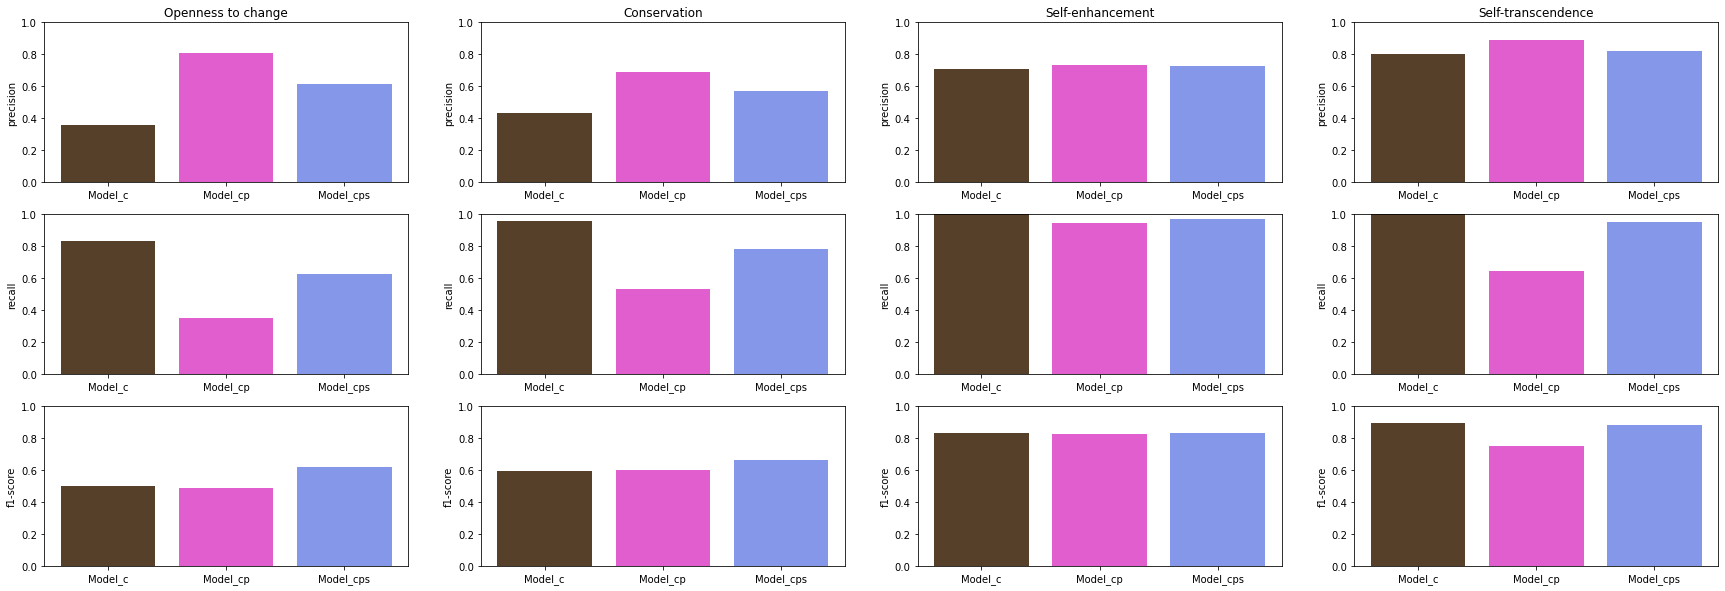

Model_c results:
                    precision    recall  f1-score   support

Openness to change       0.35      0.83      0.50       474
      Conservation       0.43      0.96      0.59       647
  Self-enhancement       0.71      1.00      0.83      1119
Self-transcendence       0.80      1.00      0.89      1268

         micro avg       0.60      0.97      0.74      3508
         macro avg       0.57      0.95      0.70      3508
      weighted avg       0.64      0.97      0.76      3508
       samples avg       0.60      0.98      0.72      3508

                    precision    recall  f1-score   support

Openness to change       0.81      0.35      0.49       474
      Conservation       0.69      0.53      0.60       647
  Self-enhancement       0.74      0.94      0.83      1119
Self-transcendence       0.89      0.65      0.75      1268

         micro avg       0.78      0.68      0.73      3508
         macro avg       0.78      0.62      0.67      3508
      weighted avg

In [91]:
# for each model I plot the f1-score of each category for the test set using classification_report

report_results_c = classification_report(targets_c, predictions_c, target_names=labels ,zero_division=1, output_dict=True)
report_results_cp = classification_report(targets_cp, predictions_cp, target_names=labels ,zero_division=1, output_dict=True)
report_results_cps = classification_report(targets_cps, predictions_cps, target_names=labels ,zero_division=1, output_dict=True)
all_reports = [report_results_c, report_results_cp, report_results_cps]

plot_colors = set_color(len(all_reports))

# I plot the precision, recall and f1-score for each category for each model.
fig, axs = plt.subplots(3, len(labels), figsize=(30, 10))

for i, metric in enumerate(['precision', 'recall', 'f1-score']):
    for j, label in enumerate(labels):
        for k, report in enumerate(all_reports):
            axs[i, j].bar(k, report[label][metric], color=plot_colors[k])
            if k == 0 : axs[k, j].set_title(label)
            axs[k, j].set_xticks([0, 1, 2])
            axs[k, j].set_xticklabels(['Model_c', 'Model_cp', 'Model_cps'])
            axs[k, j].set_ylim([0, 1])
            axs[i, j].set_ylabel(metric)

            
plt.show()
# i print model_c results
print("Model_c results:")
print(classification_report(targets_c, predictions_c, target_names=labels ,zero_division=1))
print(classification_report(targets_cp, predictions_cp, target_names=labels ,zero_division=1))
print(classification_report(targets_cps, predictions_cps, target_names=labels ,zero_division=1))